# Task 3: Watermark Removal from Grayscale Images Using Pixel Adjacency Analysis

### Pipeline Walk-through:
- **Reading and Displaying the Image:** The grayscale image is loaded using OpenCV (cv2.imread) and displayed using Matplotlib for verification. If the image file is not found, an error is raised.

- **Detecting the Watermark:** The watermark region is detected using intensity thresholding (cv2.threshold) and morphological operations (cv2.morphologyEx). A refined binary mask is created to isolate the watermark from the background.

- **Removing the Watermark:** The detected watermark region is filled by averaging the intensity values of its neighboring pixels. Multiple iterations can be applied to ensure smoother restoration.

- **Smoothing and Refining the Image:** A spatial filtering technique (median filtering or box blur) is applied to remove artifacts and blend the filled region naturally with the surrounding pixels.

- **Saving the Processed Image:** The final processed image is saved in a specified directory (../results). If a previous version of the file exists, it is deleted before saving the new output.

- **Executing the Full Processing Pipeline:** A single function process_pipeline automates the entire workflow, from watermark detection to removal, refinement, and saving the final output.

### Setup and Imports

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

### (Pipeline Implementation)

In [86]:
class WatermarkRemover:
    """
    A class to detect and remove a visible watermark from a grayscale image
    using only pixel adjacency analysis and spatial filtering.
    
    Steps:
        1. Read/Store the image (Grayscale).
        2. Detect the watermark by thresholding + connected components.
        3. Create a binary mask isolating the watermark.
        4. Remove the watermark by filling its region with local neighbor averages.
        5. Smooth and refine the filled region using spatial filtering.
        6. Provide or save the final, watermark-free image.
    """
    
    def __init__(self, image_path, threshold_value=180, kernel_size=3, fill_iterations=1):
        """
        Initializes the WatermarkRemover class.

        Args:
            image_path (str): Path to the input grayscale image.
            threshold_value (int): Intensity threshold to detect the watermark region.
            kernel_size (int): Size of the morphological operation kernel.
            fill_iterations (int): Number of passes to fill the watermark region (more passes may improve results).
        """
        # Reading the grayscale image
        self.image_path = image_path
        
        self.original_image = self.read_image()

        filename = os.path.basename(self.image_path)

        self.image_name, ext = os.path.splitext(filename)
        
        self.threshold_value = threshold_value
        self.kernel_size = kernel_size
        self.fill_iterations = fill_iterations
        
        # Internal placeholders for intermediate results
        self.binary_mask = None
        self.restored_image = None
        self.smoothed_image = None
        
        # Storing dimensions for convenience
        self.height, self.width = self.original_image.shape

    def read_image(self):
        """
        Reads the image in grayscale and displays it.
        Returns:
            image (numpy.ndarray): The grayscale image.
        """
        image = cv2.imread(self.image_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            raise FileNotFoundError(f"Image file '{self.image_path}' not found.")

        self.display_image(image, "Original Image")

        return image

    def display_image(self, image, title="Image"):
        """
        Displays an image using matplotlib.
        Args:
            image (numpy.ndarray): Image to display.
            title (str): Title for the displayed image.
        """
        plt.figure(figsize=(6,6))

        plt.imshow(image, cmap='gray')

        plt.title(title)

        plt.axis('off')

        plt.show()

    def detect_watermark(self):
        """
        Detects the watermark region using a combination of:
         - Simple thresholding (global or adaptive).
         - Connected components or morphological operations to refine the mask.
        
        Explanation:
            1. Thresholding separates the (likely brighter) watermark pixels from the background.
            2. A morphological operation (opening) helps remove noise or small irrelevant regions.
            3. We produce a binary mask where mask[y,x] = 1 if it's a watermark pixel, else 0.
        """
        # Thresholding the image
        # The threshold_value can be adjusted based on how bright/dark the watermark is.
        # _, thresh = cv2.threshold(
        #     self.original_image, self.threshold_value, 255, cv2.THRESH_BINARY
        # )
        _, thresh = cv2.threshold(self.original_image, self.threshold_value, 255, cv2.THRESH_BINARY_INV)

        
        # Refining the mask with morphological opening
        #    Opening = Erosion followed by Dilation; it removes small white noise (pecks).
        kernel = np.ones((self.kernel_size, self.kernel_size), np.uint8)
        refined_mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

        self.display_image(refined_mask, "Refined Mask")
        
        # Converting the refined mask to boolean form
        self.binary_mask = refined_mask > 0

        self.display_image(self.binary_mask, "Binary Mask")

    def remove_watermark(self):
        """
        Removes the watermark by filling the detected region with
        an average of neighboring pixel values (not in the watermark).

        Explanation:
            - We create a copy of the original image in float32 format (for easy averaging).
            - For each pixel in the mask, we look at the 8-connected neighbors.
            - If a neighbor is not part of the watermark, we gather its intensity for averaging.
            - We perform multiple iterations to gradually fill from outside in (if desired).
        """
        # If the mask was not created yet, detect the watermark first
        # if self.binary_mask is None:
        #     self.detect_watermark()   

        if not hasattr(self, 'binary_mask'):
            raise ValueError("Mask was not created yet, detect the watermark first")

        # Converting the original image to float for averaging
        restored = self.original_image.astype(np.float32).copy()
        
        # Coordinates of all pixels in the mask
        mask_points = np.argwhere(self.binary_mask)

        # Define 8-connected neighbor offsets
        neighbor_offsets = [
            (-1, -1), (-1, 0), (-1, 1),
            ( 0, -1),          ( 0, 1),
            ( 1, -1), ( 1, 0), ( 1, 1)
        ]
        
        # Repeating the filling process for the specified number of iterations
        for _ in range(self.fill_iterations):
            
            for (y, x) in mask_points:
                valid_neighbors = []
            
                for (dy, dx) in neighbor_offsets:
                    ny, nx = y + dy, x + dx
            
                    # Checking image bounds
                    if 0 <= ny < self.height and 0 <= nx < self.width:
                        
                        # Only considering neighbor if it's not in the watermark
                        if not self.binary_mask[ny, nx]:
                            valid_neighbors.append(restored[ny, nx])
                
                # If we have valid neighbors, average them; else, fallback to original
                if len(valid_neighbors) > 0:
                    restored[y, x] = np.mean(valid_neighbors)
                else:
                    restored[y, x] = self.original_image[y, x]

        # Storing the intermediate restored result
        self.restored_image = restored

    def smooth_and_refine(self, method="median", ksize=9):
        """
        Applies a spatial filter (median or box blur) to blend the filled region with the surroundings.

        Args:
            method (str): "median" or "box" to specify which filter to use.
            ksize (int): Kernel size for smoothing.

        Explanation:
            - After filling the watermark region, edges might be abrupt.
            - A median or box (mean) filter helps smooth transitions.
            - The smoothing can be applied to the entire image or selectively to the mask boundary.
        """
        # if self.restored_image is None:
        #     self.remove_watermark()

        if not hasattr(self, 'remove_watermark'):
            raise ValueError("Watermark was not removed yet, run remove_watermark first")
        
        # Converting restored float image to uint8
        restored_uint8 = self.restored_image.astype(np.uint8)
        
        if method == "median":
            # Median filter is good at removing salt-and-pepper noise and smoothing edges gently
            self.smoothed_image = cv2.medianBlur(restored_uint8, ksize)
        elif method == "box":
            # Box filter (mean blur) for simpler smoothing
            self.smoothed_image = cv2.blur(restored_uint8, (ksize, ksize))
        else:
            raise ValueError("Unknown smoothing method. Use 'median' or 'box'.")

    def save_output(self, output_path):
        """
        Saves the final, watermark-removed image to disk.

        Args:
            output_path (str): Where to save the restored image.

        Explanation:
            - The final image (self.smoothed_image) should look natural
              with minimal artifacts or abrupt transitions.
        """
        if self.smoothed_image is None:
            # If smoothing wasn't called, just save the restored image (no smoothing)
            if self.restored_image is not None:
                to_save = self.restored_image.astype(np.uint8)
            else:
                raise ValueError("No image available to save. Please run remove_watermark() first.")
        else:
            to_save = self.smoothed_image

        self.display_image(to_save, "Restored Image")
        
        self.save_image(output_path, to_save)

    def save_image(self, save_path, to_save):
        """
        Saves the binarized image to the specified path.
        If the file already exists, it is deleted before saving the new image.
        Args:
            save_path (str): Path to save the processed image.
        """
        # Defining the target directory
        results_dir = os.path.join("../results")
        
        # Creating the directory if it does not exist
        os.makedirs(results_dir, exist_ok=True)
        
        # Constructing the full path for saving the image
        full_save_path = os.path.join(results_dir, f"{save_path}{self.image_name}_restored.png")
        
        # Removing existing file if it exists
        if os.path.exists(full_save_path):
            os.remove(full_save_path)
        
        # Saving the image
        cv2.imwrite(full_save_path, to_save)
        
        print(f"Image saved at {full_save_path}")

    def get_result(self):
        """
        Returns the final smoothed image in NumPy array format (H x W).
        
        Explanation:
            - Useful if you want to process the result further in memory.
        """
        if self.smoothed_image is not None:
            return self.smoothed_image
        elif self.restored_image is not None:
            return self.restored_image.astype(np.uint8)
        else:
            raise ValueError("No result yet. Please run remove_watermark() and/or smooth_and_refine().")
        
    def process_pipeline(self, save_path):
        """
        Runs the complete watermark removal pipeline:
            1. Detect watermark.
            2. Remove watermark.
            3. Smooth and refine the result.
            4. Save the final image.
        """
        self.detect_watermark()
        self.remove_watermark()
        self.smooth_and_refine()
        self.save_output(save_path)


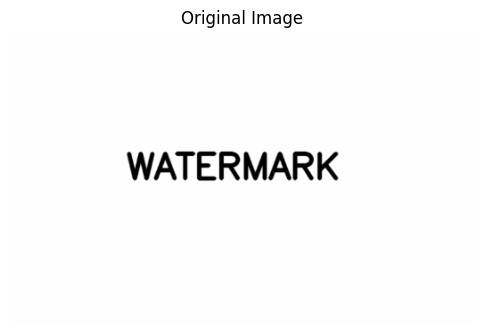

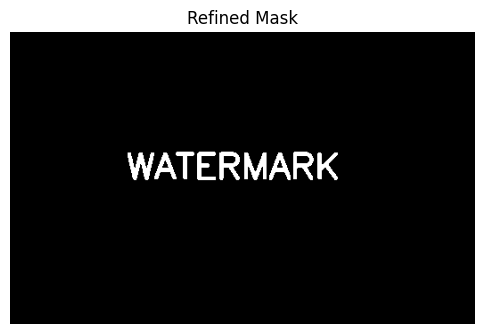

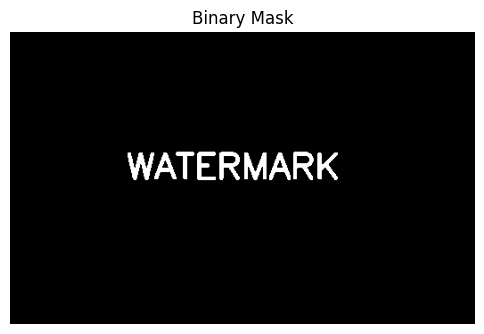

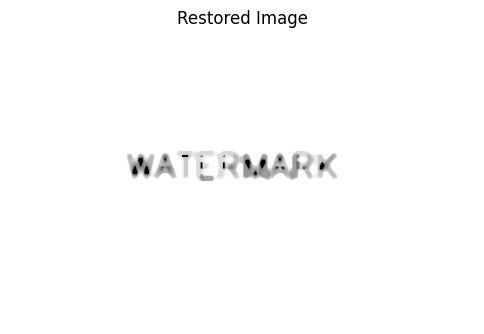

Image saved at ../results\../results/image_q3_restored.png


In [ ]:

remover = WatermarkRemover(
    image_path="../data/image_t3.png", 
    threshold_value=110,  # Adjust based on watermark brightness
    kernel_size=3,        # Morphological kernel size
    fill_iterations=15     # Number of passes for filling
)

remover.process_pipeline("../results/")


# Task 2: Grayscale Image Processing and Enhancement

### Pipeline walk-through:
- **Reading and Displaying the Image**
    We use OpenCV to load the image in grayscale. Displaying the original image helps verify that we start with the correct input.
- **Noise Reduction**
    We apply a median filter (using cv2.medianBlur) which is effective at removing high-frequency noise while preserving edges. A kernel size of 3 (an odd integer) is a common starting point.
- **Contrast Enhancement**
    The digits are of low contrast. Here, a log transformation is used. This transformation maps lower intensity values to a broader range, thereby brightening the digits relative to the background. We compute a scaling constant and apply the transformation.
- **Laplacian Sharpening**
    To make the edges of the digits more distinct, we apply a Laplacian filter. This filter emphasizes areas of rapid intensity change (edges). We then subtract the Laplacian from the enhanced image to “sharpen” it.
- **Binarization**
    Finally, we convert the sharpened image to binary. We demonstrate both global thresholding (if the background is uniformly lit) and adaptive thresholding (for uneven lighting conditions). In this case, using `cv2.THRESH_BINARY_INV` ensures that the digits become black (0) and the background white (255).
- **Output and Intermediate Results**
    At each step, we display the intermediate results using matplotlib.pyplot so you can verify the progress of your processing. The final binary image is saved to a file.

**Note:** Remember, the parameters (such as kernel sizes, threshold values, and transformation constants) may need adjustment based on your specific images. Experiment with these values until you achieve the best result.

### Setup and Imports

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

### (Pipeline) Implementation

In [84]:
class ImageProcessor:

    def __init__(self, image_path):
        """
        Initialize the ImageProcessor with the path to the grayscale image.
        Reads and displays the original image.
        """
        self.image_path = image_path
        self.original = self.read_image()

        filename = os.path.basename(self.image_path)

        self.image_name, ext = os.path.splitext(filename)

        # print(self.image_name)  # For, testing

    def read_image(self):
        """
        Reads the image in grayscale and displays it.
        Returns:
            image (numpy.ndarray): The grayscale image.
        """
        image = cv2.imread(self.image_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            raise FileNotFoundError(f"Image file '{self.image_path}' not found.")

        self.display_image(image, "Original Image")

        return image

    def display_image(self, image, title="Image"):
        """
        Displays an image using matplotlib.
        Args:
            image (numpy.ndarray): Image to display.
            title (str): Title for the displayed image.
        """
        plt.figure(figsize=(6,6))

        plt.imshow(image, cmap='gray')

        plt.title(title)

        plt.axis('off')

        plt.show()

    def reduce_noise(self, kernel_size=3, method="median"):  # Or even 9 for stronger noise reduction
        """
        Reduces high-frequency noise using a median filter.
        Args:
            kernel_size (int): Size of the median filter kernel (must be an odd integer).
        Returns:
            median_filtered (numpy.ndarray): The noise-reduced image.
        """
        if method == "median":
            self.noise_filtered = cv2.medianBlur(self.original, kernel_size)
        if method == "gaussian":
            self.noise_filtered = cv2.GaussianBlur(self.original, (kernel_size, kernel_size), 1.5)
        if method == "bilateral": # This can remove noise while keeping digit edges clearer.
            self.noise_filtered = cv2.bilateralFilter(self.original, 9, 75, 75)

        # In many OCR or digit-recognition pipelines, a slight blur can actually improve thresholding results because it helps unify strokes. The key is to not blur so aggressively that digits lose shape.

        self.display_image(self.noise_filtered, "After Noise Reduction")

        return self.noise_filtered

    def enhance_contrast(self, method="gamma", gamma=2.0):
        """
        Enhances contrast using either Log or Gamma (Power-law) transformation.
        Args:
            method (str): 'log' for Log transformation, 'gamma' for Power-law transformation.
            gamma (float): Gamma value for Power-law transformation (default=1.5).
        Returns:
            contrast_enhanced (numpy.ndarray): The contrast-enhanced image.
        """
        if not hasattr(self, 'noise_filtered'):
            raise ValueError("Please apply noise reduction before contrast enhancement.")

        if method == "log":
            # Log transformation is less effective for images with uneven lighting.
            c = 255 / np.log(1 + np.max(self.noise_filtered))
            contrast_enhanced = c * np.log(1 + self.noise_filtered.astype(np.float64))
            contrast_enhanced = np.array(contrast_enhanced, dtype=np.uint8)
        elif method == "gamma":
            # # Gamma correction allows more flexible enhancement.
            # If digits look too dark after enhancement, increase gamma (e.g., gamma=2.0).
            # If digits become too bright, lower gamma (e.g., gamma=1.2).
            contrast_enhanced = np.power(self.noise_filtered / 255.0, gamma) * 255
            contrast_enhanced = contrast_enhanced.astype(np.uint8)
        else:
            raise ValueError("Invalid contrast enhancement method. Choose 'log' or 'gamma'.")

        self.contrast_enhanced = contrast_enhanced
        self.display_image(self.contrast_enhanced, f"Contrast Enhancement ({method.capitalize()})")

        return self.contrast_enhanced

    def laplacian_sharpen(self):
        """
        Sharpens the contrast-enhanced image using a Laplacian filter.
        Returns:
            sharpened (numpy.ndarray): The sharpened image.
        """
        if not hasattr(self, 'contrast_enhanced'):
            raise ValueError("Please enhance contrast before applying Laplacian sharpening.")
        
        laplacian = cv2.Laplacian(self.contrast_enhanced, cv2.CV_64F, ksize=3)

        # Converting laplacian to uint8
        laplacian = np.uint8(np.absolute(laplacian))
        
        # Weighted combination: alpha = strength of original image, beta = strength of edges
        alpha, beta = 1.5, -0.5
        sharpened = cv2.addWeighted(self.contrast_enhanced, alpha, -laplacian, beta, 0)
        sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
        self.sharpened = sharpened
        
        self.display_image(self.sharpened, "After Laplacian Sharpening")
        
        return self.sharpened

    def binarize(self, method="global", threshold=127):
        """
        Converts the sharpened image into a binary (black-and-white) image.
        Args:
            method (str): 'global' for global thresholding or 'adaptive' for adaptive thresholding.
            threshold (int): Threshold value for global thresholding.
        Returns:
            binary_image (numpy.ndarray): The binarized image.
        """
        if not hasattr(self, 'sharpened'):
            raise ValueError("Please sharpen the image before binarization.")
        
        if method == "global":
            ret, self.binary_image = cv2.threshold(
                self.sharpened, threshold, 255, cv2.THRESH_BINARY_INV)
        
            self.display_image(self.binary_image, "Final Binary Image (Global Thresholding)")
        elif method == "adaptive":
            # Increase block size if digits vary in local contrast
            block_size = 15
            C = 2  
            self.binary_image = cv2.adaptiveThreshold(
                self.sharpened, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY_INV, block_size, C
            )
        
            self.display_image(self.binary_image, "Final Binary Image (Adaptive Thresholding)")
        else:
            raise ValueError("Invalid method specified. Choose 'global' or 'adaptive'.")
    
        # Morphological Opening or Closing (optional)
        kernel = np.ones((3,3), np.uint8)
        
        # morphological opening to remove noise (if you have both noise specks)
        self.binary_image = cv2.morphologyEx(self.binary_image, cv2.MORPH_OPEN, kernel)
        self.display_image(self.binary_image, "After Morphological Opening")

        # # (If digits are broken, you might try morphological closing or a combination)
        # self.binary_image = cv2.morphologyEx(self.binary_image, cv2.MORPH_CLOSE, kernel)
        # self.display_image(self.binary_image, "After Morphological Closing")

        # # Summary:
        # Even with the best denoising, your final binarization can make or break digit clarity. If you see fragmented digits or leftover noise:

        # Adaptive Thresholding: Increase or decrease the block_size or C to better isolate digits.
        # Morphological Opening: Removes leftover small specks after thresholding.
        # Morphological Closing: Reconnects broken parts of digits
        
        return self.binary_image

    def save_image(self, save_path):
        """
        Saves the binarized image to the specified path.
        If the file already exists, it is deleted before saving the new image.
        Args:
            save_path (str): Path to save the processed image.
        """
        # Defining the target directory
        results_dir = os.path.join("../results")
        
        # Creating the directory if it does not exist
        os.makedirs(results_dir, exist_ok=True)
        
        # Constructing the full path for saving the image
        full_save_path = os.path.join(results_dir, f"{save_path}_{self.image_name}_processed.png")
        
        # Removing existing file if it exists
        if os.path.exists(full_save_path):
            os.remove(full_save_path)

        if not hasattr(self, 'binary_image'):
            raise ValueError("Binarization has not been performed. Nothing to save.")
        
        # Saving the image
        cv2.imwrite(full_save_path, self.binary_image)
        
        print(f"Image saved at {full_save_path}")

    def process_pipeline(self, save_path):
        """
        Runs the complete image processing pipeline and saves the final image.
        Args:
            save_path (str): Path where the final image will be saved.
            threshold (int): Threshold value for global thresholding.
            method (str): 'global' or 'adaptive' thresholding method.
        """
        ## Sample hyperparameters:
        # noise_method="median", 
        # noise_kernel=7, 
        # contrast_method="gamma", 
        # gamma=2.0,
        # sharpen_alpha=1.5, 
        # sharpen_beta=-0.5,
        # bin_method="adaptive",
        # block_size=15, 
        # C=2

        self.reduce_noise()
        self.enhance_contrast()
        self.laplacian_sharpen()
        self.binarize()
        self.save_image(save_path)

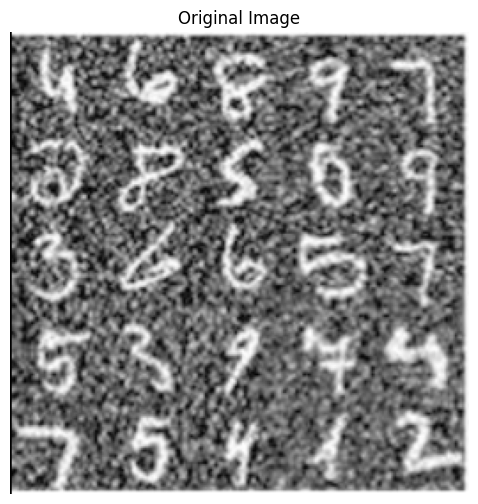

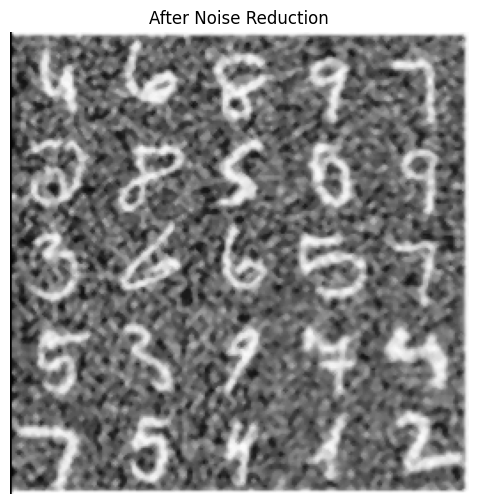

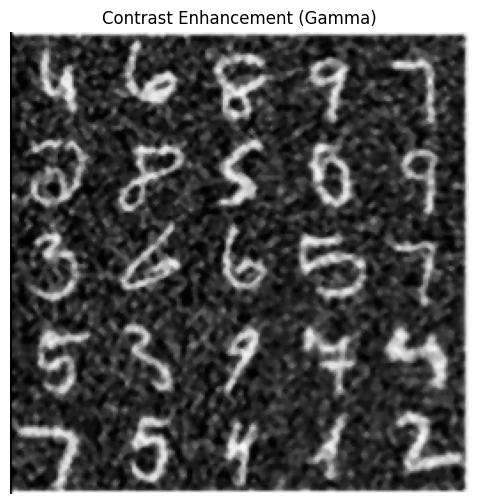

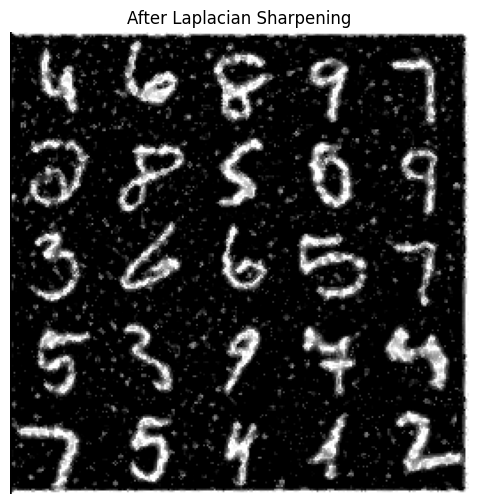

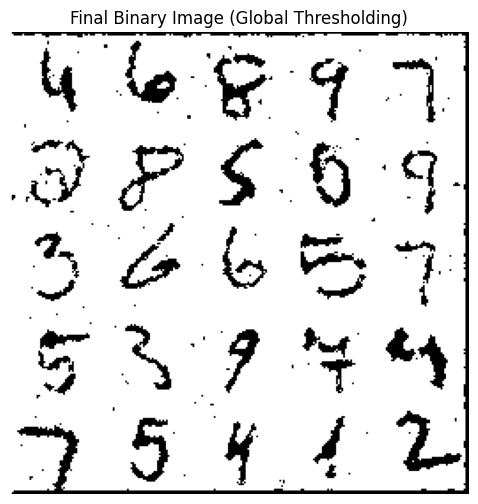

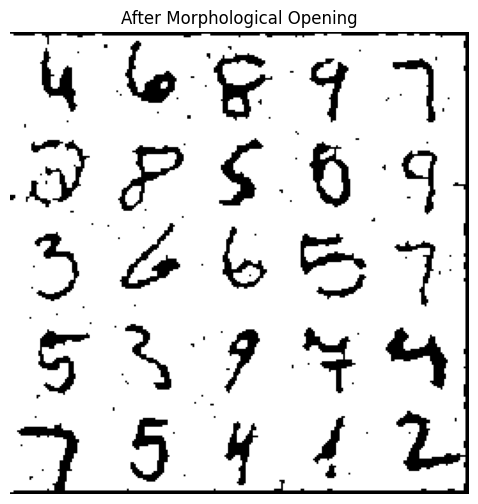

Image saved at ../results\../results/binary_image_q2_processed.png


In [ ]:
processor = ImageProcessor('../data/image_12.png')

# Running the complete processing pipeline and save the final image
processor.process_pipeline('../results/binary')

# Task 1: Background Removal in Video Processing

### Pipeline Walk-through:
- **Initialization and Parameter Setup:** The BackgroundRemover class is initialized with various parameters, including input/output video paths, threshold values, kernel sizes for filtering, and options for dynamic background modeling. These parameters control how the background is detected and processed.

- **Frame Extraction from Video:** The extract_frames method reads the video file, extracts each frame, and converts them to grayscale. It also determines the video's frame rate and resolution, which will be used for processing and reconstruction.

- **Custom Background Creation:** The custom_background_loader method generates a uniform grayscale background image and saves it. This custom background will later replace the detected background in the processed frames.

- **Background Model Initialization:** The initialize_background_model method loads and resizes the custom background image. Depending on whether a static or dynamic background is selected, it either sets the first frame as the reference background or initializes a running average model for adaptive background detection.

- **Gamma Correction for Enhanced Visibility:** The gamma_correct method adjusts the brightness of frames using gamma correction to enhance contrast and visibility of moving objects.

- **Frame Processing for Background Removal:** The process_frames method performs background subtraction using absolute frame differences. A threshold is applied to create a binary mask that separates foreground from background. This mask is refined using smoothing (box filter) and noise reduction (median filter). The refined mask is then used to replace the background pixels with the custom background.

- **Normalization of Processed Frames:** The normalize_frame method ensures that all pixel values remain within the valid range (0–255), preventing artifacts in the final output.

- **Reconstruction of Processed Video:** The reconstruct_video method combines the processed frames back into a video file using OpenCV’s VideoWriter, maintaining the original frame rate and resolution.

- **Pipeline Execution:** The run method executes the entire background removal pipeline step by step, from frame extraction to video reconstruction.

### Setup and Imports

In [20]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

### (Pipeline) Implementation

In [16]:
class BackgroundRemover:
    
    def __init__(self, input_video_path, output_video_path, custom_bg_path,
                 threshold=30, box_kernel=(5, 5), median_kernel=5,
                 dynamic_bg=False, alpha=0.005):
        """
        Initializes the BackgroundRemover with required parameters.
        
        :param input_video_path: Path to the input video.
        :param output_video_path: Path where the output video will be saved.
        :param custom_bg_path: Path to the custom background image (grayscale).
        :param threshold: Threshold value for binary mask creation.
        :param box_kernel: Kernel size for box filter.
        :param median_kernel: Kernel size for median filter.
        :param dynamic_bg: Boolean flag; if True, use a running average for a dynamic background.
        :param alpha: Learning rate for running average (only used if dynamic_bg is True).
        """
        self.input_video_path = input_video_path
        self.output_video_path = output_video_path
        self.custom_bg_path = custom_bg_path
        self.threshold = threshold
        self.box_kernel = box_kernel
        self.median_kernel = median_kernel
        self.dynamic_bg = dynamic_bg
        self.alpha = alpha  # used for updating the dynamic background model
        
        self.frames = []             # To store all video frames
        self.processed_frames = []   # To store processed frames
        self.fps = None              # Frame rate of the input video
        self.frame_size = None       # (width, height) of the video frames
        self.bg_model = None         # Background model (reference frame or running average)
        self.custom_bg = None        # Custom background image (grayscale)

    # def read_image(self):
    #     """
    #     Reads the image in grayscale and displays it.
    #     Returns:
    #         image (numpy.ndarray): The grayscale image.
    #     """
    #     image = cv2.imread(self.image_path, cv2.IMREAD_GRAYSCALE)

    #     if image is None:
    #         raise FileNotFoundError(f"Image file '{self.image_path}' not found.")

    #     self.display_image(image, "Original Image")

    #     return image

    def display_image(self, image, title="Image"):
        """
        Displays an image using matplotlib.
        Args:
            image (numpy.ndarray): Image to display.
            title (str): Title for the displayed image.
        """
        plt.figure(figsize=(6,6))

        plt.imshow(image, cmap='gray')

        plt.title(title)

        plt.axis('off')

        plt.show()

    def extract_frames(self):
        """Extracts and converts all video frames to grayscale."""
        cap = cv2.VideoCapture(self.input_video_path)
        
        if not cap.isOpened():
            raise IOError("Error opening video file.")
        
        self.fps = cap.get(cv2.CAP_PROP_FPS)
        ret, frame = cap.read()

        self.h, self.w = frame.shape[:2]

        # print(f"Height: {self.h}, Width: {self.w}") # For, testing
        
        while ret:
            # Converting to grayscale if the frame is not already grayscale
            if len(frame.shape) == 3:
                gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            else:
                gray_frame = frame
            
            # Setting frame size (width, height) from the first frame
            if self.frame_size is None:
                self.frame_size = (gray_frame.shape[1], gray_frame.shape[0])
            
            self.frames.append(gray_frame)
            ret, frame = cap.read()

        cap.release()
        
        print(f"Extracted {len(self.frames)} frames from video.")

        self.custom_background_loader(self.h, self.w)

        print("\nCustom background image loaded.")

    def custom_background_loader(self, height, width):
        # # Creating a grayscale background image with a gradient
        # background = np.zeros((height, width), dtype=np.uint8)

        # # Filling the image with a gradient
        # for i in range(height):
            
        #     for j in range(width):
        #         background[i, j] = int((i + j) / (height + width) * 255)

        # Creating a uniform mid-gray background (e.g., 127)
        background = np.full((height, width), 0, dtype=np.uint8)

        # # Displaying the image
        # cv2.imshow('Grayscale Background', background)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        # Defining the path to save the image
        save_path = self.custom_bg_path

        # Checking if the image already exists and delete it if it does
        if os.path.exists(save_path):
            os.remove(save_path)

        # Saving the new image as a .jpg file
        cv2.imwrite(save_path, background)
    
    def initialize_background_model(self):
        """
        Loads and resizes the custom background image.
        Initializes the background model:
          - For static background, use the first frame.
          - For dynamic background, initialize a running average.
        """
        # Loading custom background image in grayscale and resize it to the frame size
        self.custom_bg = cv2.imread(self.custom_bg_path, cv2.IMREAD_GRAYSCALE)
        
        if self.custom_bg is None:
            raise IOError("Custom background image not found.")
        
        self.custom_bg = cv2.resize(self.custom_bg, self.frame_size)
        
        # Initializing background model
        if not self.dynamic_bg:
            # Static background: use the first frame as reference
            self.bg_model = self.frames[0]
        else:
            # Dynamic background: use the first frame as the initial model in float32 format
            self.bg_model = self.frames[0].astype(np.float32)

    def gamma_correct(self, image, gamma=1.2):
        # Build a lookup table first
        invGamma = 1.0 / gamma
        table = np.array([(i / 255.0) ** invGamma * 255 
                        for i in np.arange(256)]).astype("uint8")
        return cv2.LUT(image, table)
    
    def process_frames(self):
        """Processes each frame: background detection, mask refinement, and background replacement."""
        print()

        for i, frame in enumerate(self.frames):
            # self.display_image(frame, f"Frame {i+1}")

            # Updating background model dynamically if required
            if self.dynamic_bg:
                # Accumulating weighted average (running average)
                cv2.accumulateWeighted(frame, self.bg_model, self.alpha)
                bg_frame = cv2.convertScaleAbs(self.bg_model)
            else:
                bg_frame = self.bg_model

            # self.display_image(bg_frame, "Background Model")
            
            # Computing the difference between the current frame and the background model.
            # Using cv2.subtract helps avoid negative values, but if you use direct subtraction,
            # you might need to normalize negative values later.
            # diff = cv2.subtract(frame, bg_frame)
            corrected_frame = self.gamma_correct(frame, gamma=1.2)
            diff = cv2.absdiff(frame, bg_frame) # absdiff takes the absolute difference of the two images, helping capture both lighter and darker variations that occur when the subject moves through shadows.

            # self.display_image(diff, "Difference Image")
            
            # Threshold the difference to create a binary mask (foreground vs. background)
            # _, mask = cv2.threshold(diff, self.threshold, 255, cv2.THRESH_BINARY)
            # If 30 is missing parts of the subject, try lowering to 20, 15, or even 10
            _, mask = cv2.threshold(diff, 20, 255, cv2.THRESH_BINARY)

            # self.display_image(mask, "Binary Mask")
            
            # Refining the mask:
            # Smoothing the mask using a box (averaging) filter.
            mask_smooth = cv2.blur(mask, self.box_kernel)
            # Further reducing noise with a median filter.
            mask_refined = cv2.medianBlur(mask_smooth, self.median_kernel)
            
            # To clearly distinguish the foreground, threshold the refined mask.
            # _, final_mask = cv2.threshold(mask_refined, 127, 255, cv2.THRESH_BINARY)
            # Instead of thresholding at 127 again:
            final_mask = mask_refined
            # Or, if needed, adjust the threshold value based on your observations.
            
            # Creating an inverse mask for background replacement.
            bg_mask = cv2.bitwise_not(final_mask)
            
            # Copying the current frame for background replacement.
            processed_frame = frame.copy()
            # Replacing background pixels (where bg_mask is 255) with the custom background.
            processed_frame[bg_mask == 255] = self.custom_bg[bg_mask == 255]
            
            # Handling any negative pixel values via normalization.
            processed_frame = self.normalize_frame(processed_frame)
            
            self.processed_frames.append(processed_frame)

            print(f"Processed frame {i+1} of {len(self.frames)}")
    
    def normalize_frame(self, frame):
        """
        Normalizes the frame so that all pixel values fall between 0 and 255.
        This method checks for negative values and applies a shift-and-scale if necessary.
        """
        min_val = np.min(frame)

        if min_val < 0:
            # Shifting values so that the minimum becomes 0
            frame = frame - min_val
            # Scaling the image so the maximum is 255
            frame = (frame / np.max(frame)) * 255
            frame = frame.astype(np.uint8)

        return frame
    
    def reconstruct_video(self):
        """Recombines the processed frames into a new video with the same fps and frame size."""
        # Defining the codec and create VideoWriter object.
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(self.output_video_path, fourcc, self.fps, self.frame_size, isColor=False)
        
        for i, frame in enumerate(self.processed_frames):
            out.write(frame)

        out.release()
        
        print(f"\nVideo reconstruction complete. Output saved to {self.output_video_path}")
    
    def run(self):
        """Executes the full pipeline: frame extraction, background modeling, processing, and reconstruction."""
        self.extract_frames()
        self.initialize_background_model()
        self.process_frames()
        self.reconstruct_video()

In [ ]:
# Paths for the input video, custom background image, and output video.
input_video_path = "../data/video_t1.mp4"          
output_video_path = "../results/output_video_t1.avi"  
custom_bg_path = "../data/custom_background.jpg"   

# Setting dynamic_bg to True if the background is slightly changing; otherwise, use static background.
bg_remover = BackgroundRemover(input_video_path, output_video_path, custom_bg_path,
                            threshold=30, box_kernel=(5, 5), median_kernel=5,
                            dynamic_bg=True, alpha=0.05)

# Running the background removal and replacement process.
bg_remover.run()

Extracted 150 frames from video.

Custom background image loaded.

Processed frame 1 of 150
Processed frame 2 of 150
Processed frame 3 of 150
Processed frame 4 of 150
Processed frame 5 of 150
Processed frame 6 of 150
Processed frame 7 of 150
Processed frame 8 of 150
Processed frame 9 of 150
Processed frame 10 of 150
Processed frame 11 of 150
Processed frame 12 of 150
Processed frame 13 of 150
Processed frame 14 of 150
Processed frame 15 of 150
Processed frame 16 of 150
Processed frame 17 of 150
Processed frame 18 of 150
Processed frame 19 of 150
Processed frame 20 of 150
Processed frame 21 of 150
Processed frame 22 of 150
Processed frame 23 of 150
Processed frame 24 of 150
Processed frame 25 of 150
Processed frame 26 of 150
Processed frame 27 of 150
Processed frame 28 of 150
Processed frame 29 of 150
Processed frame 30 of 150
Processed frame 31 of 150
Processed frame 32 of 150
Processed frame 33 of 150
Processed frame 34 of 150
Processed frame 35 of 150
Processed frame 36 of 150
Proces

In [32]:
class BackgroundRemover1:
    
    def __init__(self, input_video_path, output_video_path, custom_bg_path,
                 threshold=30, box_kernel=(5, 5), median_kernel=5,
                 dynamic_bg=True, alpha=0.001):
        """
        Initializes the BackgroundRemover with required parameters.
        
        :param input_video_path: Path to the input video.
        :param output_video_path: Path where the output video will be saved.
        :param custom_bg_path: Path to the custom background image (grayscale).
        :param threshold: Threshold value for binary mask creation.
        :param box_kernel: Kernel size for box filter.
        :param median_kernel: Kernel size for median filter.
        :param dynamic_bg: Boolean flag; if True, use a running average for a dynamic background.
        :param alpha: Learning rate for running average (only used if dynamic_bg is True).
        """
        self.input_video_path = input_video_path
        self.output_video_path = output_video_path
        self.custom_bg_path = custom_bg_path
        self.threshold = threshold
        self.box_kernel = box_kernel
        self.median_kernel = median_kernel
        self.dynamic_bg = dynamic_bg
        self.alpha = alpha  # used for updating the dynamic background model
        
        self.frames = []             # To store all video frames
        self.processed_frames = []   # To store processed frames
        self.fps = None              # Frame rate of the input video
        self.frame_size = None       # (width, height) of the video frames
        self.bg_model = None         # Background model (reference frame or running average)
        self.custom_bg = None        # Custom background image (grayscale)

    def display_image(self, image, title="Image"):
        """
        Displays an image using matplotlib.
        Args:
            image (numpy.ndarray): Image to display.
            title (str): Title for the displayed image.
        """
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(6,6))
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()

    def extract_frames(self):
        """Extracts and converts all video frames to grayscale."""
        import cv2
        
        cap = cv2.VideoCapture(self.input_video_path)
        
        if not cap.isOpened():
            raise IOError("Error opening video file.")
        
        self.fps = cap.get(cv2.CAP_PROP_FPS)
        
        ret, frame = cap.read()

        self.h, self.w = frame.shape[:2]
        
        while ret:
            # Converting to grayscale if the frame is not already grayscale
            if len(frame.shape) == 3:
                gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            else:
                gray_frame = frame
            
            # Setting frame size (width, height) from the first frame
            if self.frame_size is None:
                self.frame_size = (gray_frame.shape[1], gray_frame.shape[0])
            
            self.frames.append(gray_frame)
            ret, frame = cap.read()

        cap.release()
        
        print(f"Extracted {len(self.frames)} frames from video.")

        self.custom_background_loader(self.h, self.w)
        
        print("\nCustom background image loaded.")

    def custom_background_loader(self, height, width):
        """
        Creates a custom uniform background image and saves it.
        """
        import cv2, os, numpy as np
        
        # Creating a uniform black background (all zeros). Adjust value if needed.
        background = np.full((height, width), 0, dtype=np.uint8)

        save_path = self.custom_bg_path
        
        if os.path.exists(save_path):
            os.remove(save_path)
        
        cv2.imwrite(save_path, background)
    
    def initialize_background_model(self):
        """
        Loads and resizes the custom background image.
        Initializes the background model using a robust approach:
          - Instead of using just the first frame, use the median of the first N frames.
          - For static background, this median is used as the reference.
          - For dynamic background, this serves as the initial model (in float32).
        """
        import cv2, numpy as np
        
        # Loading and resizing custom background image
        self.custom_bg = cv2.imread(self.custom_bg_path, cv2.IMREAD_GRAYSCALE)
        
        if self.custom_bg is None:
            raise IOError("Custom background image not found.")
        
        self.custom_bg = cv2.resize(self.custom_bg, self.frame_size)
        
        # Robust initialization: use median of first N frames
        N = min(10, len(self.frames))
        
        initial_frames = self.frames[:N]
        
        self.bg_model = np.median(np.stack(initial_frames), axis=0).astype(np.float32)
        # For static mode, we keep the bg_model fixed.
        # For dynamic mode, we'll update bg_model selectively in process_frames.

    def gamma_correct(self, image, gamma=1.2):
        """
        Applies gamma correction to adjust brightness.
        """
        import cv2, numpy as np
        
        invGamma = 1.0 / gamma
        
        table = np.array([(i / 255.0) ** invGamma * 255 
                        for i in np.arange(256)]).astype("uint8")
        
        return cv2.LUT(image, table)
    
    def process_frames(self):
        """Processes each frame: background subtraction, mask refinement, and background replacement."""
        import cv2, numpy as np
        
        print()
        for i, frame in enumerate(self.frames):
            # Applying gamma correction to current frame for consistency
            corrected_frame = self.gamma_correct(frame, gamma=1.2)
            
            # Getting the current background frame from the model and apply gamma correction
            bg_frame = cv2.convertScaleAbs(self.bg_model)
            corrected_bg = self.gamma_correct(bg_frame, gamma=1.2)
            
            # Computing the absolute difference between the gamma-corrected frame and background
            diff = cv2.absdiff(corrected_frame, corrected_bg)
            
            # Using the provided threshold (adaptive thresholding can be implemented as needed)
            # _, mask = cv2.threshold(diff, self.threshold, 255, cv2.THRESH_BINARY)

            # Defining parameters for adaptive thresholding
            block_size = 11  # Must be an odd number (e.g., 11, 15, 21) and greater than 1
            C = 2            # Constant subtracted from the computed mean or weighted sum

            # Applying adaptive thresholding on the difference image 'diff'
            mask = cv2.adaptiveThreshold(diff, 
                                        255, 
                                        # cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                        cv2.ADAPTIVE_THRESH_MEAN_C,
                                        cv2.THRESH_BINARY, 
                                        block_size, 
                                        C)
            
            # Mask refinement: smoothing with box filter, median filter, then morphological operations
            mask_smooth = cv2.blur(mask, self.box_kernel)
            mask_refined = cv2.medianBlur(mask_smooth, self.median_kernel)
            
            # # Morphological opening and closing to remove small artifacts
            # kernel = np.ones((3, 3), np.uint8)
            # refined_mask = cv2.morphologyEx(mask_refined, cv2.MORPH_OPEN, kernel)
            # refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_CLOSE, kernel)
            
            # Optional: apply a slight Gaussian blur to soften edges for smoother background replacement
            # final_mask = cv2.GaussianBlur(refined_mask, (3, 3), 0)
            final_mask = cv2.GaussianBlur(mask_refined, (3, 3), 0)
            
            # Creating an inverse mask for background replacement
            bg_mask = cv2.bitwise_not(final_mask)
            
            # Replacing background: copy frame then replace pixels where bg_mask is 255 with custom background pixels
            processed_frame = frame.copy()
            processed_frame[bg_mask == 255] = self.custom_bg[bg_mask == 255]
            
            # Normalizing processed frame to ensure pixel values are within 0-255
            processed_frame = self.normalize_frame(processed_frame)
            self.processed_frames.append(processed_frame)
            
            # If dynamic background mode is enabled, update the background model selectively:
            # Only update background pixels (where final_mask indicates background)
            if self.dynamic_bg:
                background_pixels = cv2.bitwise_not(final_mask)
                cv2.accumulateWeighted(frame, self.bg_model, self.alpha, mask=background_pixels)
            
            print(f"Processed frame {i+1} of {len(self.frames)}")
    
    def normalize_frame(self, frame):
        """
        Normalizes the frame so that all pixel values fall between 0 and 255.
        """
        import numpy as np
        
        min_val = np.min(frame)
        
        if min_val < 0:
            frame = frame - min_val
            frame = (frame / np.max(frame)) * 255
            frame = frame.astype(np.uint8)
        
        return frame
    
    def reconstruct_video(self):
        """Recombines the processed frames into a new video with the same fps and frame size."""
        import cv2
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        
        out = cv2.VideoWriter(self.output_video_path, fourcc, self.fps, self.frame_size, isColor=False)
        
        for frame in self.processed_frames:
            out.write(frame)
        
        out.release()
        
        print(f"\nVideo reconstruction complete. Output saved to {self.output_video_path}")
    
    def run(self):
        """Executes the full pipeline: frame extraction, background modeling, processing, and reconstruction."""
        self.extract_frames()
        self.initialize_background_model()
        self.process_frames()
        self.reconstruct_video()


In [33]:
# Paths for the input video, custom background image, and output video.
input_video_path = "../data/video_q1.mp4"          
output_video_path = "../results/output_video_1.avi"  
custom_bg_path = "../data/custom_background.jpg"   

# Setting dynamic_bg to True if the background is slightly changing; otherwise, use static background.
bg_remover = BackgroundRemover1(input_video_path, output_video_path, custom_bg_path,
                            threshold=20, box_kernel=(5, 5), median_kernel=5,
                            dynamic_bg=True, alpha=0.001)

# Running the background removal and replacement process.
bg_remover.run()

Extracted 150 frames from video.

Custom background image loaded.

Processed frame 1 of 150
Processed frame 2 of 150
Processed frame 3 of 150
Processed frame 4 of 150
Processed frame 5 of 150
Processed frame 6 of 150
Processed frame 7 of 150
Processed frame 8 of 150
Processed frame 9 of 150
Processed frame 10 of 150
Processed frame 11 of 150
Processed frame 12 of 150
Processed frame 13 of 150
Processed frame 14 of 150
Processed frame 15 of 150
Processed frame 16 of 150
Processed frame 17 of 150
Processed frame 18 of 150
Processed frame 19 of 150
Processed frame 20 of 150
Processed frame 21 of 150
Processed frame 22 of 150
Processed frame 23 of 150
Processed frame 24 of 150
Processed frame 25 of 150
Processed frame 26 of 150
Processed frame 27 of 150
Processed frame 28 of 150
Processed frame 29 of 150
Processed frame 30 of 150
Processed frame 31 of 150
Processed frame 32 of 150
Processed frame 33 of 150
Processed frame 34 of 150
Processed frame 35 of 150
Processed frame 36 of 150
Proces